In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

Сгенерируем датасет Игрушка Дьявола

In [2]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear

N = 1000
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j, N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 8, (j + 1) * 8, N) + np.random.randn(N) * 0.7  # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

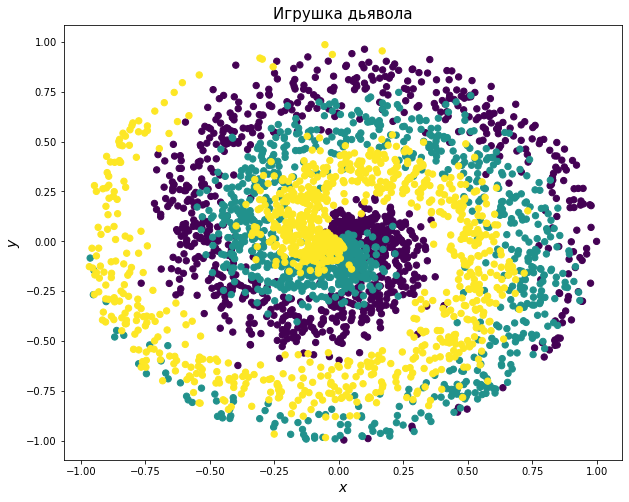

In [3]:
# Отрисовочная магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

plt.figure(figsize=(10, 8))

plt.scatter(X[:, 0], X[:, 1], c=y, s=40)

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

In [4]:
X = torch.FloatTensor(X).to('cuda:0')
y = torch.LongTensor(y).to('cuda:0')

Сейчас мы хотим научиться самостоятельно создавать наследников nn.Module. До этого мы делали нейросети с помощью класса nn.Sequential, попробуем построить такую же сеть, как на прошлом семинаре, но самостоятельно.


In [5]:
# СЕТЬ С ПРОШЛОГО СЕМИНАРА

# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
D_in, H, D_out = 2, 100, 3

# Use the nn package to define our model and loss function.
two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.Softmax(dim=1)
).to('cuda:0')

In [6]:
loss_fn = nn.CrossEntropyLoss().to('cuda:0')
optim = torch.optim.Adam(two_layer_net.parameters(), 1e-1)

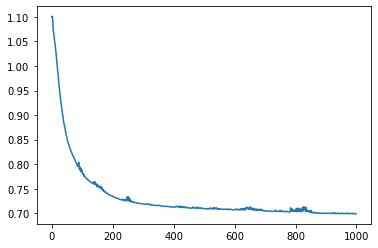

In [7]:
losses = []
for t in range(1000):
    # forward
    y_pred = two_layer_net(X)

    # loss
    loss = loss_fn(y_pred, y)
    losses.append(loss.item())

    optim.zero_grad()
    loss.backward()
    optim.step()

plt.plot(losses);

In [8]:
model_preds = two_layer_net(X)
preds = torch.FloatTensor().to('cuda:0')
markers = torch.IntTensor().to('cuda:0')

for line in model_preds:
    preds = torch.cat((preds, torch.max(line).unsqueeze(0)), dim=0)
    markers = torch.cat((markers, torch.argmax(line).unsqueeze(0)), dim=0)

In [9]:
df = pd.DataFrame()

markers_cpu = markers.cpu()
X = X.cpu()

df['x'] = X[:, 0]
df['y'] = X[:, 1]
df['marker'] = markers_cpu.numpy()

df['marker'] = df['marker'].astype(int)

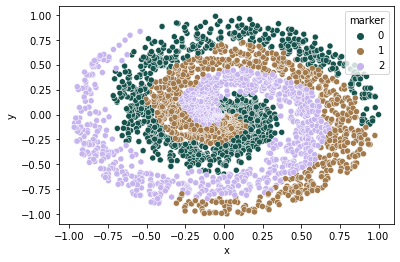

In [10]:
sns.scatterplot(data=df, x='x', y='y', hue='marker', palette=sns.color_palette("cubehelix", n_colors=3));

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
y = y.cpu()

In [13]:
print(accuracy_score(y.numpy(), df['marker']))

0.8553333333333333
